In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Rice_Citation_Request.txt
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (11154).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8058).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5150).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8267).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8747).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (2970).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (10959).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (4976).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (730).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (9279).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (534).jpg
/kaggle/i

In [2]:
import torch
import warnings
warnings.filterwarnings("ignore")
from numpy import asarray
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import glob
import os
import gc
import time
import random
import subprocess
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image, ImageDraw
from skimage.io import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tabulate import tabulate
from IPython.display import display, HTML


# >> PyTorch:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import colorama
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, ToTensor, Normalize
from colorama import Fore, Style

In [3]:
print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0+cu124


# List the folder's name of Dataset

In [16]:
from pathlib import Path

# مسیر دیتاست
data_dir = Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')

# لیست پوشه‌ها (هر پوشه = یک کلاس برنج)
class_names = [f.name for f in data_dir.iterdir() if f.is_dir()]

print("کلاس‌های دیتاست (انواع برنج):")
for i, c in enumerate(sorted(class_names)):
    print(f"{i+1}. {c}")


کلاس‌های دیتاست (انواع برنج):
1. Arborio
2. Basmati
3. Ipsala
4. Jasmine
5. Karacadag


Create a master data set.

In [17]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# Simple Transform for testing
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# تعریف Dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Data sharing
# تقسیم داده‌ها
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len   = int(0.15 * total_len)
test_len  = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# DataLoaderها
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 52500, Val: 11250, Test: 11250


In [6]:
import torch

# بررسی اینکه GPU در دسترس است یا نه
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# تعداد GPUها
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# نام GPU (اگر موجود باشد)
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


Device: cuda
CUDA available: True
Number of GPUs: 2
GPU Name: Tesla T4


# **I labeled
# to tansor  کردن

In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1. Define transforms
# for train: with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # augmentation
    transforms.RandomRotation(10),      # augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# برای val/test: بدون augmentation
# # for val/test: no augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Dataset path (for Kaggle)
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# 3. Load the full dataset with test_transform (initially without augmentation)
full_dataset = datasets.ImageFolder(data_dir, transform=test_transform)

# ۴. تقسیم به train/val/test (80% train, 10% val, 10% test)
# 4. Split into train/val/test (80% train, 10% val, 10% test)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# ۵. اعمال augmentation فقط روی train (اینجا مشکل حل می‌شه!)
# 5. Apply augmentation only to train (this solves the problem!)
train_dataset.dataset.transform = train_transform

# ۶. DataLoaderها
# 6. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("تقسیم‌بندی و augmentation آماده‌ست!")

تقسیم‌بندی و augmentation آماده‌ست!


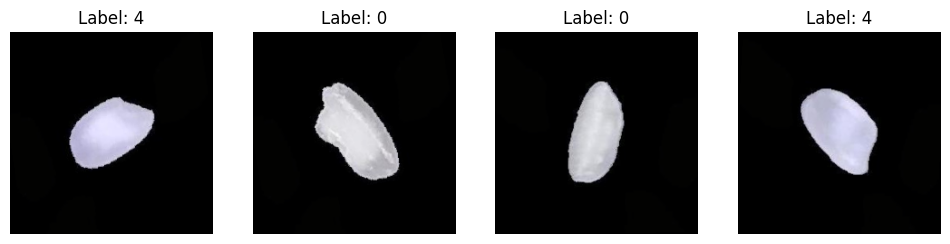

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# گرفتن یک batch از train_loader
# # Get a batch from train_loader
images, labels = next(iter(train_loader))  # images: [B, C, H, W]

# مقادیر mean و std (از transform اصلی)
# # mean and std values ​​(from the original transform)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Show the first 4 images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i]  # [C, H, W]
    img_np = img.permute(1, 2, 0).numpy()  # به [H, W, C]
    
# Denormalize to display colors correctly
    img_denorm = (img_np * std + mean).clip(0, 1)  # کلیپ بین 0 و 1
    
    axes[i].imshow(img_denorm)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')
plt.show()

# 
Comparing labels with Pandas to verify correctnessمقایسه لیبل ها با پانداس برای تاییدی درستی کار

In [27]:
# فرض dataset = ImageFolder(data_dir)
labels = np.array(dataset.targets)  # Fast and without reading images
df = pd.DataFrame({'label': labels})

# Number of each class
print(df['label'].value_counts())


label
0    15000
1    15000
2    15000
3    15000
4    15000
Name: count, dtype: int64


CrossEntropyLoss در PyTorch است، که یکی از رایج‌ترین loss functionها برای classification است
CrossEntropyLoss in PyTorch is one of the most common loss functions for classification.

In [10]:
import os

print(os.listdir(data_dir))  # ببین فولدر کلاس‌ها درست هستند


['Karacadag', 'Basmati', 'Jasmine', 'Rice_Citation_Request.txt', 'Arborio', 'Ipsala']


این فایل از خود dataset دانلود شده از Kaggle آمده 

اکثر datasetهای بزرگ، علاوه بر تصاویر، یک فایل متنی یا PDF برای منبع/حق نشر/License هم دارند.

له، دقیقاً! چون datasets.ImageFolder فقط فولدرها رو به عنوان کلاس‌ها می‌خونه و فایل‌های غیرفولدر مثل 'Rice_Citation_Request.txt' رو کامل نادیده می‌گیره، هیچ خطایی ایجاد نمی‌شه. دیتاستت با همون ۵ کلاس (Karacadag, Basmati, Jasmine, Arborio, Ipsala) درست لود می‌شه و آماده استفاده‌ست
----

This file is from the dataset itself downloaded from Kaggle 

Most large datasets, in addition to the images, also have a text or PDF file for the source/copyright/license.

Yep, exactly! Because datasets.ImageFolder only reads folders as classes and completely ignores non-folder files like 'Rice_Citation_Request.txt', no errors are thrown. The dataset with the same 5 classes (Karacadag, Basmati, Jasmine, Arborio, Ipsala) is loaded correctly and ready to use.

# ConvBlock 

In [29]:
import torch
import torch.nn as nn

# کانولوشن بلاک با دو Conv پشت سر هم
# # Block convolution with two consecutive Conv
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.block(x)


# مدل اصلی
# # Original model
class RiceClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(RiceClassifier, self).__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Use on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RiceClassifier(num_classes=5).to(device)
print("مدل جدید ساخته شد ✅")


مدل جدید ساخته شد ✅


In [30]:
# Get only class folders (directories only)
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print("کلاس‌ها:", classes)

labels = []
for cls in classes:
    cls_folder = os.path.join(data_dir, cls)
    files = [f for f in os.listdir(cls_folder) if os.path.isfile(os.path.join(cls_folder, f))]
    labels.extend([cls] * len(files))

df = pd.DataFrame({'label': labels})

print("تعداد هر کلاس:")
print(df['label'].value_counts())

کلاس‌ها: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
تعداد هر کلاس:
label
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64


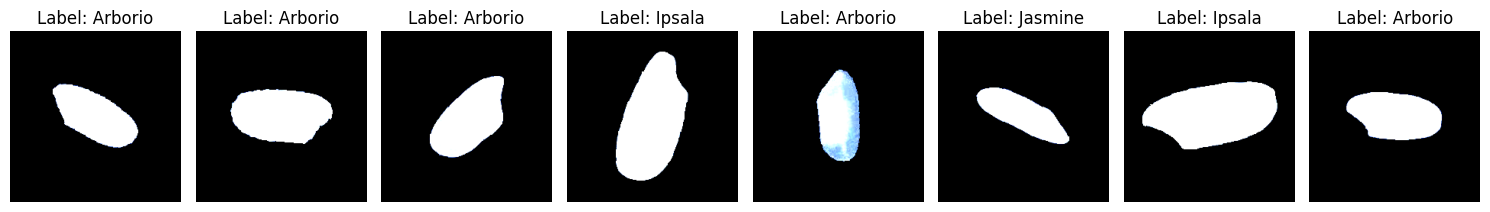

In [31]:

def imshow(img, title):
    """
    Show an image
    """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# تعیین تعداد تصاویری که می‌خواهید نمایش دهید
# # Determine the number of images you want to display
num_images = 8

# یک نمونه تصادفی از تصاویر را می‌گیریم
# We take a random sample of images.
random_indices = np.random.choice(len(full_dataset), size=num_images, replace=False)

#Show images
plt.figure(figsize=(15, 6))
for i, index in enumerate(random_indices):
    image, label = full_dataset[index]
    
    # پیدا کردن نام کلاس از روی ایندکس لیبل
    # فرض می‌کنیم full_dataset.classes لیستی از نام کلاس‌ها باشد
    # اگر اینطور نیست، باید mapping خود را بسازید
    # Find class name from label index
# Assume full_dataset.classes is a list of class names
# If not, you need to create your own mapping



    
    class_name = full_dataset.classes[label]
    
    plt.subplot(1, num_images, i + 1)
    imshow(image, title=f"Label: {class_name}")

plt.tight_layout()
plt.show()


# انتخاب ترخ یادگیری مناسب....اتصال بهینه....learning rate
# ۱. تعریف DataLoaders از PyTorch Datasetها
# ۲. تعریف Learner با مدل، تابع loss و معیار ارزیابی
# ۳. پیدا کردن نرخ یادگیری بهینه قبل از شروع آموزش
# ۴. آموزش مدل با fit_one_cycle

# Choosing the right learning rate....optimal connection....learning rate
# 1. Defining DataLoaders from PyTorch Datasets
# 2. Defining Learner with model, loss function and evaluation criterion
# 3. Finding the optimal learning rate before starting training
# 4. Training the model with fit_one_cycle


**  فریم ور ک   fast ai

تعداد کلاس‌ها: 5
کلاس‌ها: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
تعداد تصاویر آموزشی: 60000
تعداد تصاویر اعتبارسنجی: 15000


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s] 


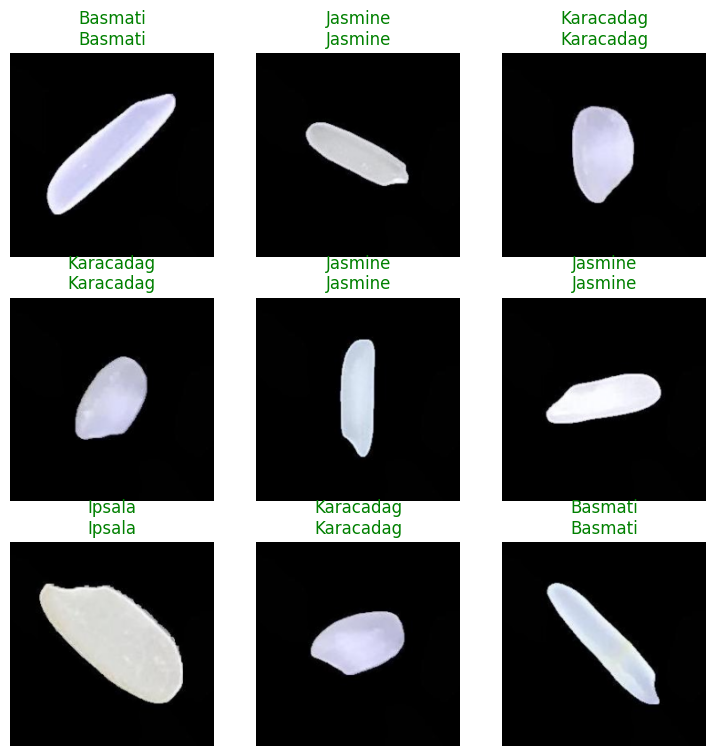

In [1]:
from fastai.vision.all import *

# Dataset path
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# Load the dataset with ImageDataLoaders
dls = ImageDataLoaders.from_folder(
    path=data_dir,
    valid_pct=0.2,  #20% for validation
    seed=42, # For repeatability
    item_tfms=Resize(224),  # Resize images
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],  # augmentation و نرمال‌سازی
    bs=16  # batch sizeSmall for testing
)

# چک دیتالودر
# Check Dataloader
print(f"تعداد کلاس‌ها: {len(dls.vocab)}")
print(f"کلاس‌ها: {dls.vocab}")
print(f"تعداد تصاویر آموزشی: {len(dls.train_ds)}")
print(f"تعداد تصاویر اعتبارسنجی: {len(dls.valid_ds)}")

# Model definition
learn = vision_learner(dls, resnet18, metrics=accuracy)

# Model training
learn.fit_one_cycle(5, lr_max=1e-2)

# Show results
learn.show_results()

مدل ساده تر زدم تتا بتونم vaild
هم ببینم

I made a simpler model so I could also see vaild.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

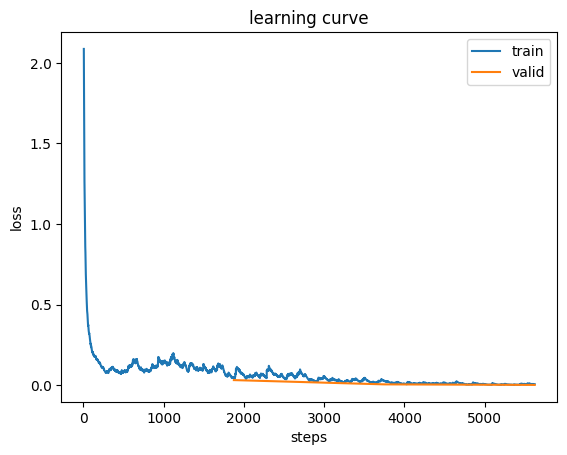

In [2]:
from fastai.vision.all import *



# DataLoaders با تقسیم خودکار 20٪ برای validation
# # DataLoaders with automatic 20% split for validation
dls = ImageDataLoaders.from_folder(
    data_dir,
    valid_pct=0.2,  # 20% for validation
    seed=42,
    item_tfms=Resize(128),  #Smaller for quick testing
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    bs=32
)

# Model definition
learn = vision_learner(dls, resnet18, metrics=accuracy)

# Model training
learn.fit_one_cycle(3, lr_max=1e-2)

# loss chart
learn.recorder.plot_loss()


In [3]:
learn.recorder.values  # لیست لیست‌های [train_loss, valid_loss, accuracy, ...]


[(#3) [0.04840545356273651,0.032690275460481644,0.9911333322525024],
 (#3) [0.025823384523391724,0.00622289115563035,0.9980000257492065],
 (#3) [0.00752898957580328,0.0027604319620877504,0.9991999864578247]]

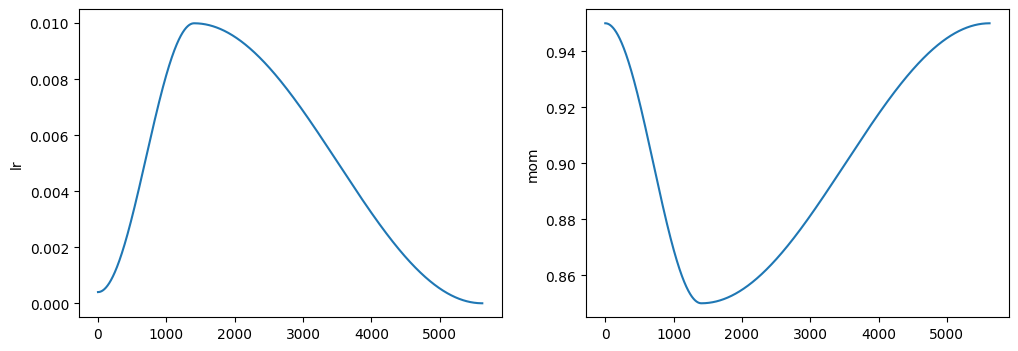

In [5]:
learn.recorder.plot_sched()


. ۱ تا ۲ اپاک (Epoch) برای رسیدن به خطای پایین و همگرایی اولیه در مدل شما بسیار کم است، و این به دلیل استفاده از تکنیک‌های پیشرفته آموزش مدل در Fastai است.


1-2 epochs is very little to achieve low error and initial convergence in your model, and this is due to the use of advanced model training techniques in Fastai.

مشخض کردن هایپر پارامتر ها

Specifying hyperparameters

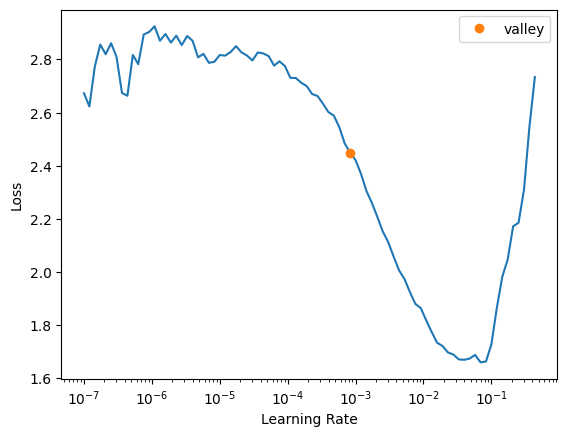

In [6]:
from fastai.vision.all import *

# Dataset path (read-only)
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# Writable path to save models
working_dir = '/kaggle/working/'

# DataLoaders
dls = ImageDataLoaders.from_folder(
    path=data_dir,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    bs=16
)

# # Learner with writable model storage path
# Learner با مسیر ذخیره مدل قابل نوشتن
learn = vision_learner(dls, resnet18, metrics=accuracy, model_dir=working_dir)

# پیدا کردن نرخ یادگیری
# # Find the learning rate
learn.lr_find()
# # Model training
# آموزش مدل
learn.fit_one_cycle(5, lr_max=1e-2)



این نمودار از متد learn.lr_find() به دست آمده و بهترین نرخ یادگیری (Learning Rate) را برای آموزش مدل شما نشان می‌دهد.

محور X: نرخ یادگیری را به صورت لگاریتمی نشان می‌دهد.

محور Y: خطای مدل (Loss) را نشان می‌دهد.

This graph is obtained from the learn.lr_find() method and shows the best learning rate for training your model.

X-axis: shows the learning rate in logarithmic form.

Y-axis: shows the model error (Loss).
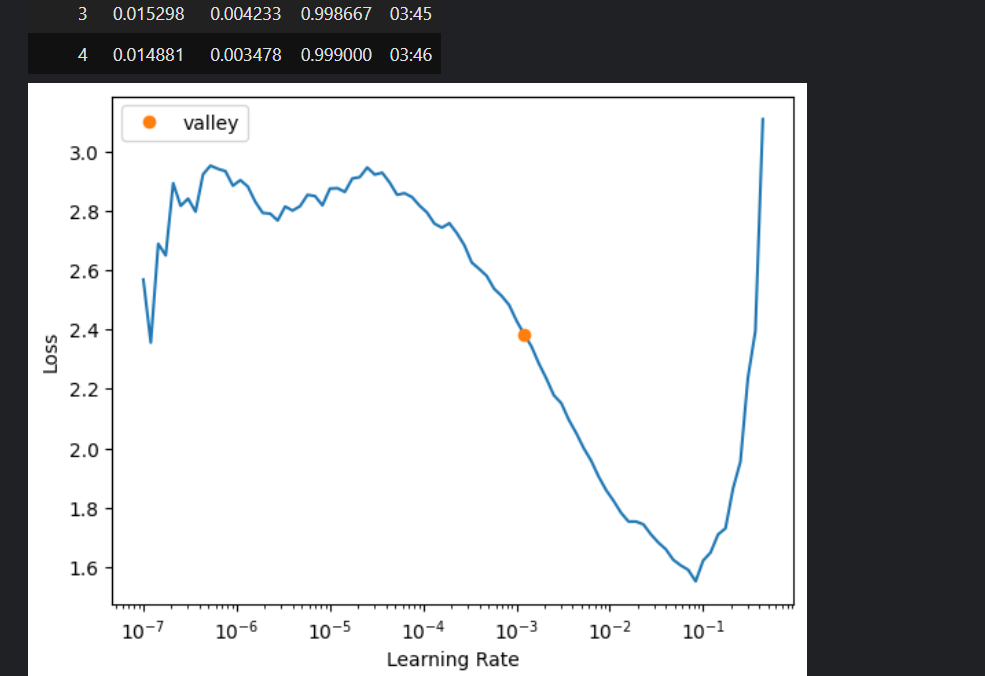

طه بهینه: نقطه نارنجی رنگ با عنوان "valley" در نمودار مشخص شده است. این نقطه جایی است که خطا به حداقل رسیده است. با توجه به این نمودار، بهترین نرخ یادگیری برای مدل شما در حدود 1e-2 (یا 0.01) است.

In [8]:
from fastai.vision.all import *
import random

# Path to the original dataset
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# DataLoaders روی subset کوچیک برای تست سریع
# # DataLoaders on a small subset for quick testing

dls = ImageDataLoaders.from_folder(
    data_dir,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(128),  # Smaller images = faster
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    bs=32,                   # Larger batch, less time.
    shuffle=True
)

# Learner
learn = vision_learner(dls, resnet18, metrics=accuracy)

# For testing only, 2 epochs are enough
learn.fit_one_cycle(4, lr_max=1e-2)

# ---- Test on a few random samples from the validation set ---
sample_indices = random.sample(range(len(dls.valid_ds)), 5)
for idx in sample_indices:
    img, label = dls.valid_ds[idx]
    pred_class, pred_idx, outputs = learn.predict(img)
    print(f"واقعی: {dls.vocab[label]}, پیش‌بینی: {pred_class}, احتمالات: {outputs}")


واقعی: Basmati, پیش‌بینی: Basmati, احتمالات: tensor([1.7579e-08, 1.0000e+00, 2.0484e-10, 2.7490e-08, 1.1376e-10])


واقعی: Basmati, پیش‌بینی: Basmati, احتمالات: tensor([2.7514e-07, 9.9992e-01, 6.5681e-08, 7.4715e-05, 4.7504e-08])


واقعی: Basmati, پیش‌بینی: Basmati, احتمالات: tensor([9.3018e-05, 6.7820e-01, 8.6799e-06, 3.2170e-01, 2.5608e-06])


واقعی: Arborio, پیش‌بینی: Arborio, احتمالات: tensor([9.4754e-01, 1.0255e-05, 3.6360e-06, 3.3019e-05, 5.2413e-02])


واقعی: Ipsala, پیش‌بینی: Ipsala, احتمالات: tensor([2.3435e-10, 1.4562e-15, 1.0000e+00, 5.3495e-13, 4.6551e-10])


# Test

In [32]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# # Put the model into evaluation mode
# مدل رو روی حالت evaluation ببریم
learn.model.eval()

all_preds = []
all_labels = []

with torch.no_grad(): # Because it is a test, there is no need to calculate the gradient
    for images, labels in test_loader:
        images, labels = images.to(learn.dls.device), labels.to(learn.dls.device)
        
        outputs = learn.model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# حالا محاسبه accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# Full report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))
# # Confusion matrix
# ماتریس درهم‌ریختگی
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.9963
              precision    recall  f1-score   support

     Arborio       0.98      1.00      0.99      1492
     Basmati       1.00      1.00      1.00      1541
      Ipsala       1.00      1.00      1.00      1498
     Jasmine       1.00      1.00      1.00      1489
   Karacadag       1.00      0.99      0.99      1480

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

[[1489    0    0    3    0]
 [   0 1539    0    2    0]
 [   1    0 1497    0    0]
 [   2    0    0 1487    0]
 [  20    0    0    0 1460]]


# Confusion Matrix

# حتی اگر accuracy خیلی بالا باشه، بررسی confusion matrix بهت نشون میده که آیا مدل کلاس‌های خاصی رو اشتباه می‌کنه یا نه.

# Even if the accuracy is very high, examining the confusion matrix will show you whether the model is getting certain classes wrong.

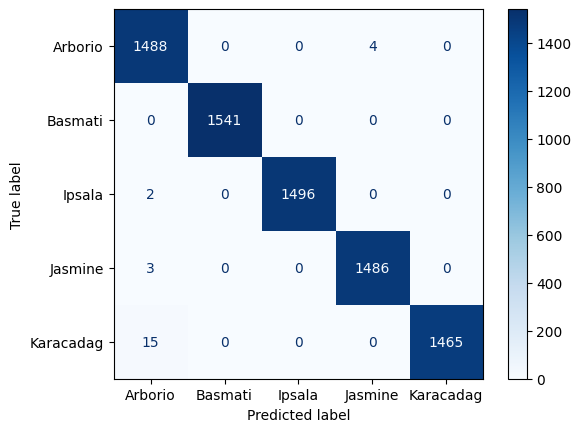

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# پیش‌بینی روی کل تست
# # Prediction on the entire test
preds, y_true = learn.get_preds(dl=test_loader)
pred_classes = preds.argmax(dim=1)

cm = confusion_matrix(y_true, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [40]:
# مسیر ذخیره قابل نوشتن
# # Writable storage path
learn.export('/kaggle/working/rice_classifier.pkl')

# پیام موفقیت
# # Success message
print("مدل با موفقیت ذخیره شد ✅")


مدل با موفقیت ذخیره شد ✅


# استفاده از آن در دنیا واقعی

# Using it in the real world

In [42]:
from fastai.vision.all import *

# 1. لود مدل ذخیره شده
# 1. Load the saved model
learn_inf = load_learner('/kaggle/working/rice_classifier.pkl')


# 2. مسیر تصویر برای تست
#2. Image path for testing
img_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Arborio/Arborio (5529).jpg'  # مثال

# 3. گرفتن پیش‌بینی
# #3. Getting a prediction
pred_class, pred_idx, outputs = learn_inf.predict(img_path)

print(f"پیش‌بینی مدل: {pred_class}")
print(f"شاخص کلاس: {pred_idx}")
print(f"احتمالات: {outputs}")


پیش‌بینی مدل: Arborio
شاخص کلاس: 0
احتمالات: tensor([1.0000e+00, 1.3907e-13, 5.5776e-12, 2.9487e-08, 8.3332e-10])


تست روی چند مدل

In [43]:
import random
from pathlib import Path

test_images = get_image_files('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')  # مسیر دیتاست تست یا کل دیتاست
sample_imgs = random.sample(test_images, 5)

for img in sample_imgs:
    pred_class, pred_idx, outputs = learn_inf.predict(img)
    print(f"تصویر: {Path(img).name}, پیش‌بینی: {pred_class}, احتمال: {outputs.max():.4f}")


تصویر: Ipsala (804).jpg, پیش‌بینی: Ipsala, احتمال: 1.0000


تصویر: Ipsala (13726).jpg, پیش‌بینی: Ipsala, احتمال: 1.0000


تصویر: Ipsala (11954).jpg, پیش‌بینی: Ipsala, احتمال: 1.0000


تصویر: Jasmine (6982).jpg, پیش‌بینی: Jasmine, احتمال: 0.9999


تصویر: Karacadag (13393).jpg, پیش‌بینی: Karacadag, احتمال: 1.0000
